# Shape asymmetry test

Test how the segmentation map is calculated in statmorph. Can we improve it?

#### Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import statmorph

# Astropy
from photutils.segmentation import detect_sources
from astropy.stats import sigma_clipped_stats
from astropy.convolution import Gaussian2DKernel, convolve, Tophat2DKernel
import scipy.ndimage as ndi
from photutils import aperture

# Galsim
from galaxy_generator import (
    get_galaxy_rng_vals, get_augmentation_rng_vals,
    simulate_perfect_galaxy, add_source_to_image, sky_noise
)

Parameters of the run:

In [2]:
perfect_pxscale = 0.1
seed = 2

## Generate the galaxy

Try to get one with actual shape asymmetry...

In [5]:
clump_properties = {
    'r' : (0.05, 1),
    'logf' : (-2, -1), # From 1% to 10% of the tital light
    'logs' : (-1.5, 0.5) 
}

gal_params = get_galaxy_rng_vals(1, clump_props=clump_properties, seed=seed)[0]
gal_params['prob_comp'] = 0

# gal_params['sersic_n'] = 1.5
aug_params = dict(sky_mag=24, pxscale=0.4)

# Perfect image
gal_perfect, gal_dict, rpet = simulate_perfect_galaxy(pxscale=perfect_pxscale, **gal_params)
gal_base = add_source_to_image(**gal_dict, pxscale=perfect_pxscale) # Apply PSF
gal_base, _ = sky_noise(gal_base, 30, perfect_pxscale)

# # Observed image
gal_lowres, gal_dict, _ = simulate_perfect_galaxy(**gal_params, **aug_params)
gal_psf = add_source_to_image(**gal_dict, **aug_params)
gal_obs, sky_flux = sky_noise(gal_psf, **aug_params)

imgs = [gal_base, gal_obs]
pxscales = [perfect_pxscale, aug_params['pxscale']]

Plot:

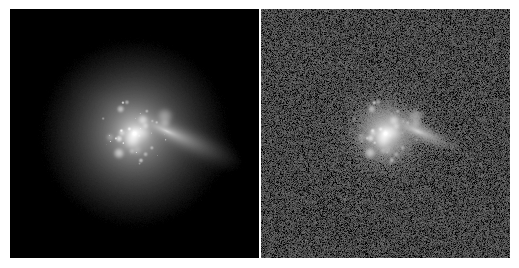

In [6]:
fig, axs = plt.subplots(1,2, figsize=(5,2.5))
axs[0].imshow(-2.5*np.log10(np.abs(gal_base)/perfect_pxscale**2)+38, vmin=18, vmax=27, cmap='gray_r')
axs[1].imshow(-2.5*np.log10(np.abs(gal_obs)/aug_params['pxscale']**2)+38, vmin=18, vmax=27, cmap='gray_r')
for ax in axs:ax.axis('off')
plt.subplots_adjust(wspace=0.01)

## Statmorph $A_s$ segmap

Copying and editing the code here so that it runs without other SM functions:

In [7]:
import photutils
from astropy.stats import sigma_clipped_stats

def get_sm_segmap(img, rpet):
    # Rpet is in pixels

        ny, nx = img.shape

        # Center at pixel that minimizes asymmetry
        center = (ny/2, nx/2)

        # Create a circular annulus around the center
        # that only contains background sky (hopefully).
        r_in = 2 * rpet
        r_out = 2.0 * 2 * rpet
        circ_annulus = photutils.aperture.CircularAnnulus(center, r_in, r_out)

        # Convert circular annulus aperture to binary mask
        circ_annulus_mask = circ_annulus.to_mask(method='center')

        # With the same shape as the postage stamp
        circ_annulus_mask = circ_annulus_mask.to_image((ny, nx))
        # Invert mask and exclude other sources
        total_mask = np.logical_not(circ_annulus_mask)

        # Define the "mode" as in Bertin & Arnouts (1996):
        bkg_estimator = photutils.background.ModeEstimatorBackground(
            median_factor=2.5, mean_factor=1.5)

        # Do sigma-clipping until convergence
        mean, median, std = sigma_clipped_stats(img, mask=total_mask, sigma=3.0, maxiters=None, cenfunc=bkg_estimator)

        # Mode as defined in Bertin & Arnouts (1996)
        mode = 2.5*median - 1.5*mean
        threshold = mode + std

        # Smooth image slightly and apply 1-sigma threshold
        image_smooth = ndi.uniform_filter(img, size=3)
        above_threshold = image_smooth >= threshold
        ic, jc = np.argwhere(image_smooth == np.max(image_smooth))[0]

        # Grow regions with 8-connected neighbor "footprint"
        s = ndi.generate_binary_structure(2, 2)
        labeled_array, num_features = ndi.label(above_threshold, structure=s)

        return labeled_array == labeled_array[ic, jc]

Generate for both images:

/tmp/ipykernel_12112/3454792782.py:12: UserWarning: The following kwargs were not used by contour: 'nlevels'
  ax.contour(segmap, nlevels=1)


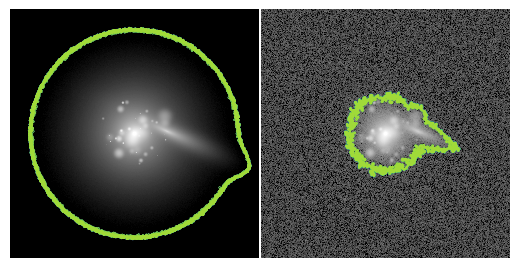

In [8]:
# Statmorph segmaps
sm_segmaps = []
for im, pxscale in zip(imgs, pxscales):
    segmap = get_sm_segmap(im, rpet/pxscale)
    sm_segmaps.append(segmap)

fig, axs = plt.subplots(1,2, figsize=(5,2.5))
axs[0].imshow(-2.5*np.log10(np.abs(gal_base)/perfect_pxscale**2)+38, vmin=18, vmax=27, cmap='gray_r')
axs[1].imshow(-2.5*np.log10(np.abs(gal_obs)/aug_params['pxscale']**2)+38, vmin=18, vmax=27, cmap='gray_r')

for ax, segmap in zip(axs, sm_segmaps):
    ax.contour(segmap, nlevels=1)

for ax in axs:ax.axis('off')
plt.subplots_adjust(wspace=0.01)

Plot the segmaps:

## SB-limited segmap

Can we define shape asymmetry as some magnitude-limited measurement? E.g., find all connected pixels with SB > threshold, where the threshold is the typical SB of the faint features we want to detect.

Otherwise, shape asymmetry is a function of the image depth, i.e. "asymmetry of features 1$\sigma$ brighter than the sky background"


In [9]:
def get_sb_segmap(img, pxscale, lim_sb=23, zp=38):
    
    kernel_size = 3
    img = ndi.gaussian_filter(img, sigma=kernel_size, truncate=2)

    
    lim_f = pxscale**2 * np.power(10, (zp-lim_sb)/2.5)
    segmap = (img > lim_f).astype(float)
    segmap_kernel = 0.005*img.shape[0]
    # segmap_kernel = 3/pxscale
    segmap = ndi.gaussian_filter(segmap, sigma=segmap_kernel, truncate=2)
    return segmap > 0.1

In [10]:
segmaps = []
pxscales = [perfect_pxscale, aug_params['pxscale']]
imgs = [gal_base, gal_obs]
for im, pxscale in zip(imgs, pxscales):
    segmap = get_sb_segmap(im, pxscale, lim_sb=20)
    segmaps.append(segmap)

/tmp/ipykernel_12112/1675248285.py:6: UserWarning: The following kwargs were not used by contour: 'nlevels'
  ax.contour(segmap, nlevels=1)


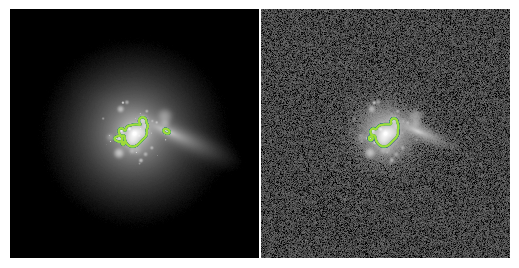

In [11]:
fig, axs = plt.subplots(1,2, figsize=(5,2.5))
axs[0].imshow(-2.5*np.log10(np.abs(gal_base)/perfect_pxscale**2)+38, vmin=18, vmax=27, cmap='gray_r')
axs[1].imshow(-2.5*np.log10(np.abs(gal_obs)/aug_params['pxscale']**2)+38, vmin=18, vmax=27, cmap='gray_r')

for ax, segmap in zip(axs, segmaps):
    ax.contour(segmap, nlevels=1)

for ax in axs:ax.axis('off')
plt.subplots_adjust(wspace=0.01)

## Vicente's idea

Measure shape asymmetry at the average SB within 1.5$R_p$. It's essentially the same as the SB segmentation map, except the SB is calculated based on the galaxy:

In [12]:
def get_avgsb_segmap(img, rpet, pxscale, ap_frac=1.5, zp=38):
    
    # Calculate average SB in an aperture
    sb = -2.5*np.log10(np.abs(img)/pxscale**2) + zp
    xc, yc = img.shape[0]/2, img.shape[1]/2
    ap = aperture.CircularAperture((xc, yc), r=ap_frac*rpet/pxscale)
    flux = ap.do_photometry(img)[0][0]
    area = ap.area * pxscale**2
    avg_sb = -2.5*np.log10(flux/area) + zp

    segmap = get_sb_segmap(img, pxscale, lim_sb=avg_sb, zp=38)
    return segmap, avg_sb, ap

In [13]:
avg_segmaps = []
aps = []
pxscales = [perfect_pxscale, aug_params['pxscale']]
imgs = [gal_base, gal_obs]
for im, pxscale in zip(imgs, pxscales):
    segmap, sb_lim, ap = get_avgsb_segmap(im, rpet, pxscale)
    print(f'{sb_lim:0.2f}', end=' ')
    avg_segmaps.append(segmap)
    aps.append(ap)

21.84 21.85 

/tmp/ipykernel_12112/2780126286.py:6: UserWarning: The following kwargs were not used by contour: 'nlevels'
  ax.contour(segmap, nlevels=1)


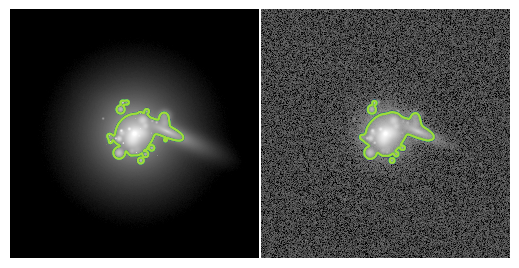

In [14]:
fig, axs = plt.subplots(1,2, figsize=(5,2.5))
axs[0].imshow(-2.5*np.log10(np.abs(gal_base)/perfect_pxscale**2)+38, vmin=18, vmax=27, cmap='gray_r')
axs[1].imshow(-2.5*np.log10(np.abs(gal_obs)/aug_params['pxscale']**2)+38, vmin=18, vmax=27, cmap='gray_r')

for ax, segmap in zip(axs, avg_segmaps):
    ax.contour(segmap, nlevels=1)
    
for ax in axs:ax.axis('off')
plt.subplots_adjust(wspace=0.01)

## Other notes 

#### Shape asymmetry citations

* Bickley's CNN paper says that Pawlik 2016 definition probes approximately SB~24.5 mag/arcsec2 asymmetries
* Zhao 2021: interesting segmentation routine for A_s https://arxiv.org/pdf/2111.03558.pdf
* Sola 2022: SB limit when creating LSB annotation maps https://arxiv.org/pdf/2203.03973.pdf
* Relevant citations here as well https://ui.adsabs.harvard.edu/abs/2023MNRAS.521.3861D/abstract

#### Procedure
* Mask other sources that are not in the segmentation map
* Subtract the background *well*
* Calculate the contour and the asymmetry of the contour shape
    * **Note** we do not use a Petrosian radius cut-off here
* Throw warning if the SB threshold is deeper than the image
    * Note: the SB limit should be redshift-dependent to be physical, accounting for cosmological SB dimming (then mag/arcsec$^2$ can be converted into solar mass/kpc$^2$)

> Another change is that the segmaps need to be smoothed *a lot more* since the shape noise disproportionately affects $A_s$ compared to $|A|$ as nothing is flux-weighted

## Code test

In [15]:
from morph_functions import shape_asymmetry, get_avgsb

In [16]:
sb_lims = [None, 24, 22, 20, 19]
as_baseline = []
as_obs = []

for lim in sb_lims:
    a_baseline = shape_asymmetry(gal_base, np.array(gal_base.shape)/2, rpet, perfect_pxscale, lim)
    a_obs = shape_asymmetry(gal_obs, np.array(gal_obs.shape)/2, rpet, aug_params['pxscale'], lim)
    as_baseline.append(a_baseline)
    as_obs.append(a_obs)

avg_sb = get_avgsb(gal_base, np.array(gal_base.shape)/2, rpet, perfect_pxscale)
sb_lims[0] = avg_sb

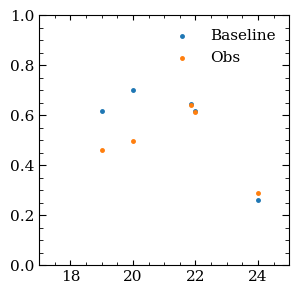

In [17]:
plt.scatter(sb_lims, as_baseline, s=50, label='Baseline')
plt.scatter(sb_lims, as_obs, s=50, label='Obs')
plt.xlim(17, 25)
plt.ylim(0, 1)
plt.legend()

## $A_s$ failure examples

### Case A: bright clumps surrounded by faint ISM

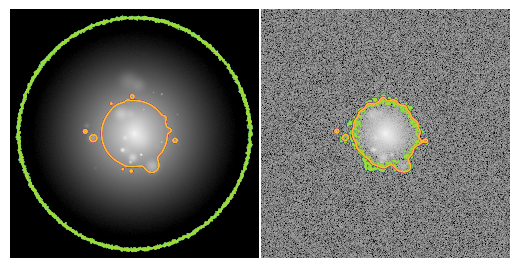

In [11]:
clump_properties = {
    'r' : (0.05, 1),
    'logf' : (-3, -1), # From 1% to 10% of the tital light
    'logs' : (-1.5, 0.5) 
}

gal_params = get_galaxy_rng_vals(1, clump_props=clump_properties, seed=seed)[0]
# gal_params['sersic_n'] = 1.5
aug_params = dict(sky_mag=22, pxscale=0.3)

# Perfect image
gal_perfect, gal_dict, rpet = simulate_perfect_galaxy(pxscale=perfect_pxscale, **gal_params)
gal_base = add_source_to_image(**gal_dict, pxscale=perfect_pxscale) # Apply PSF
gal_base, _ = sky_noise(gal_base, 30, perfect_pxscale)

# # Observed image
gal_lowres, gal_dict, _ = simulate_perfect_galaxy(**gal_params, **aug_params)
gal_psf = add_source_to_image(**gal_dict, **aug_params)
gal_obs, sky_flux = sky_noise(gal_psf, **aug_params)

imgs = [gal_base, gal_obs]
pxscales = [perfect_pxscale, aug_params['pxscale']]

# Statmorph segmaps
sm_segmaps = []
for im, pxscale in zip(imgs, pxscales):
    segmap = get_sm_segmap(im, rpet/pxscale)
    sm_segmaps.append(segmap)
    
# SB segmaps
sb_segmaps = []
for im, pxscale in zip(imgs, pxscales):
    segmap = get_sb_segmap(im, pxscale, lim_sb=22)
    sb_segmaps.append(segmap)
    
cmaps = ['viridis', 'plasma']
fig, axs = plt.subplots(1,2, figsize=(5,2.5))
axs[0].imshow(-2.5*np.log10(np.abs(gal_base)/perfect_pxscale**2)+38, vmin=18, vmax=27, cmap='gray_r')
axs[1].imshow(-2.5*np.log10(np.abs(gal_obs)/aug_params['pxscale']**2)+38, vmin=18, vmax=27, cmap='gray_r')
for i, ax in enumerate(axs):
    ax.contour(sm_segmaps[i], cmap='viridis', linewidths=1)
    ax.contour(sb_segmaps[i], cmap='plasma', linewidths=1)
for ax in axs:ax.axis('off')
plt.subplots_adjust(wspace=0.01)



* Include the clumps within Rpet

## Case B: Faint ISM

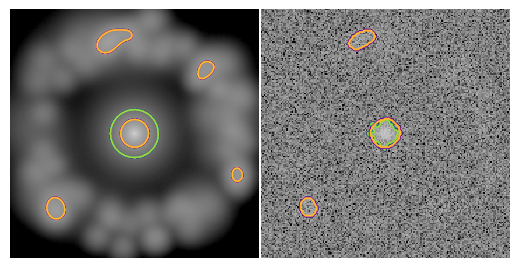

In [55]:
clump_properties = {
    'r' : (0.05, 1),
    'logf' : (-3, -1), # From 1% to 10% of the tital light
    'logs' : (-1.5, 0.5) 
}

clumps = [
    {'r' : 1, 'theta' : 0, 'flux_frac' : 0.1, 'sigma' : 1},
    {'r' : 1.3, 'theta' :15*np.pi/180, 'flux_frac' : 0.1, 'sigma' : 0.5}
]

gal_params = get_galaxy_rng_vals(1, clump_props=clump_properties, seed=5)[0]
for key in ['r','theta','flux_frac','sigma']:
    for i in range(2):
        gal_params['clump_properties'][key] = gal_params['clump_properties'][key] + [clumps[i][key]]


# gal_params['clump_properties'] = gal_params['clump_properties'] + clumps
gal_params['sersic_n'] = 1.5
aug_params = dict(sky_mag=22, pxscale=0.3)

# Perfect image
gal_perfect, gal_dict, rpet = simulate_perfect_galaxy(pxscale=perfect_pxscale, fov_reff=15, **gal_params)
gal_base = add_source_to_image(**gal_dict, pxscale=perfect_pxscale) # Apply PSF
gal_base, _ = sky_noise(gal_base, 30, perfect_pxscale)

# # Observed image
gal_lowres, gal_dict, _ = simulate_perfect_galaxy(fov_reff=15,  **gal_params, **aug_params)
gal_psf = add_source_to_image(**gal_dict, **aug_params)
gal_obs, sky_flux = sky_noise(gal_psf, **aug_params)

imgs = [gal_base, gal_obs]
pxscales = [perfect_pxscale, aug_params['pxscale']]

# Statmorph segmaps
sm_segmaps = []
for im, pxscale in zip(imgs, pxscales):
    segmap = get_sm_segmap(im, rpet/pxscale)
    sm_segmaps.append(segmap)
    
# SB segmaps
sb_segmaps = []
for im, pxscale in zip(imgs, pxscales):
    segmap = get_sb_segmap(im, pxscale, lim_sb=22)
    sb_segmaps.append(segmap)
    
cmaps = ['viridis', 'plasma']
fig, axs = plt.subplots(1,2, figsize=(5,2.5))
axs[0].imshow(-2.5*np.log10(np.abs(gal_base)/perfect_pxscale**2)+38, vmin=18, vmax=27, cmap='gray_r')
axs[1].imshow(-2.5*np.log10(np.abs(gal_obs)/aug_params['pxscale']**2)+38, vmin=18, vmax=27, cmap='gray_r')
for i, ax in enumerate(axs):
    ax.contour(sm_segmaps[i], cmap='viridis', linewidths=1)
    ax.contour(sb_segmaps[i], cmap='plasma', linewidths=1)
for ax in axs:ax.axis('off')
plt.subplots_adjust(wspace=0.01)

